## Assignment 1 - Exploring CNNs on CIFAR-10 dataset
### Team members:
#### - Kaleb Roncatti de Souza
#### - Nelson Gomes Brasil Junior

In [1]:
!pip3 install visualkeras

In [2]:
import tensorflow as tf
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
import visualkeras
import os
import random as rn
from keras import callbacks


rs = 54
# Setting up random state to specific seed so we can have reproductibility
os.environ['PYTHONHASHSEED']=str(rs)
np.random.seed(rs)
tf.random.set_seed(rs)
rn.seed(rs)

In [3]:
# Loading train and test set
(x_train , y_train), (x_test , y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
# Function to shuffle
def shuffle_tensor(x: np.ndarray , y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
    shuffled_indices = tf.random.shuffle(indices, seed=rs)
    return tf.gather(x, shuffled_indices), tf.gather(y, shuffled_indices)

# Function to split dataset
def split_dataset(x: np.ndarray, y: np.ndarray, percentage: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    if len(x) != len(y):
        raise ValueError("array x and y must have the same length")
    
    # Shuffling dataset
    x, y = shuffle_tensor(x=x, y=y)

    # Finding the splits after shuffling
    total_elements = len(y)
    data = int(percentage * total_elements)
    return x[0:data], y[0:data], x[data:], y[data:]


In [5]:
## Atividade 1. Splitting training and validation
x_train, y_train, x_val, y_val = split_dataset(x=x_train, y=y_train, percentage = 0.8)
print(f"We splitted the training dataset using the following percentage: {len(x_train)/(len(x_train) + len(x_val))}")
print(f"Training dataset has the following shape: x ==> {x_train.shape}, y ==> {y_train.shape}")
print(f"Validation dataset has the following shape: x ==> {x_val.shape}, y ==> {y_val.shape}")

We splitted the training dataset using the following percentage: 0.8
Training dataset has the following shape: x ==> (40000, 32, 32, 3), y ==> (40000, 1)
Validation dataset has the following shape: x ==> (10000, 32, 32, 3), y ==> (10000, 1)


In [6]:
# Normalize data between [0, 1]
x_train = tf.cast(x_train, tf.float32) / 255.0
x_val = tf.cast(x_val, tf.float32) / 255.0
x_test = tf.cast(x_test, tf.float32) / 255.0


# One hot encoding on labels
num_classes = len(np.unique(y_train))
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_oh = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes)
print(x_train.shape, y_train_oh.shape)

(40000, 32, 32, 3) (40000, 10)


In [7]:
# Checking if we have a balanced dataset
# Para o conjunto de treino
unique, counts = np.unique(y_train, return_counts=True)
print("Train ---> ", dict(zip(unique, counts)))
unique, counts = np.unique(y_val, return_counts=True)
print("Validation ---> ", dict(zip(unique, counts)))

Train --->  {0: 3968, 1: 4035, 2: 3988, 3: 3958, 4: 4005, 5: 4021, 6: 4038, 7: 3995, 8: 4015, 9: 3977}
Validation --->  {0: 1032, 1: 965, 2: 1012, 3: 1042, 4: 995, 5: 979, 6: 962, 7: 1005, 8: 985, 9: 1023}


We can consider that the dataset is more or less balanced. We could also adjust the weights based on their proportion, but for simplicity, let's keep going considering the dataset is completely balanced.

In [8]:
print(x_train[0].shape)

(32, 32, 3)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 10)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 10)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 10)                10010     
                                                                 
Total params: 10,290
Trainable params: 10,290
Non-trainable params: 0
_________________________________________________________________


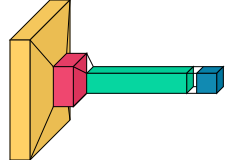

In [9]:
## Atividade 2. Creating a very simple convolutional neural net

model = tf.keras.Sequential()

# Convolutional layer with 10 filters, 3x3 each
model.add(layers.Conv2D(10, 3, padding='valid', activation='relu', input_shape=x_train[0].shape))
#Max pooling of size 3x3
model.add(layers.MaxPooling2D(pool_size=(3, 3)))
# Flattening
model.add(layers.Flatten())
# Output layer
model.add(layers.Dense(10))

model.summary()

# Taking a look at the neural net
visualkeras.layered_view(model)


In [10]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [11]:
# Training the baseline model and saving it
device = '/gpu:0' # or '/cpu:0' if you don't have GPU
with tf.device(device):
    model.fit(
        x_train, y_train_oh, 
        epochs=50, 
        batch_size=50,
        validation_data=(x_val, y_val_oh),
        verbose=1,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                'weights_baseline.h5',
                save_best_only=True,
                verbose=1),
        ]
        )

Epoch 1/50
795/800 [============================>.] - ETA: 0s - loss: 1.6409 - accuracy: 0.4153
Epoch 1: val_loss improved from inf to 1.53266, saving model to weights_baseline.h5
800/800 [==============================] - 8s 9ms/step - loss: 1.6415 - accuracy: 0.4152 - val_loss: 1.5327 - val_accuracy: 0.4691
Epoch 2/50
797/800 [============================>.] - ETA: 0s - loss: 1.5120 - accuracy: 0.4706
Epoch 2: val_loss improved from 1.53266 to 1.49671, saving model to weights_baseline.h5
800/800 [==============================] - 5s 7ms/step - loss: 1.5115 - accuracy: 0.4705 - val_loss: 1.4967 - val_accuracy: 0.4844
Epoch 3/50
795/800 [============================>.] - ETA: 0s - loss: 1.4734 - accuracy: 0.4849
Epoch 3: val_loss improved from 1.49671 to 1.45878, saving model to weights_baseline.h5
800/800 [==============================] - 6s 7ms/step - loss: 1.4728 - accuracy: 0.4850 - val_loss: 1.4588 - val_accuracy: 0.5036
Epoch 4/50
799/800 [============================>.] - ETA: 